In [9]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy
from cgi_phasec_poppy.imshows import *
from cgi_phasec_poppy.math_module import xp
reload(cgi_phasec_poppy)
data_dir = cgi_phasec_poppy.data_dir


iwa = 6
owa = 20

wavelength_c = 825e-9*u.m

nwaves = 7
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )


In [10]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])

(CGI pid=347795) 0.1 0.0072010264910560605 arcsec / pix [repeated 7x across cluster]


# Without noise

(CGI pid=347795) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 126x across cluster]
(CGI pid=339328) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 28x across cluster]
(CGI pid=339328)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 28x across cluster]


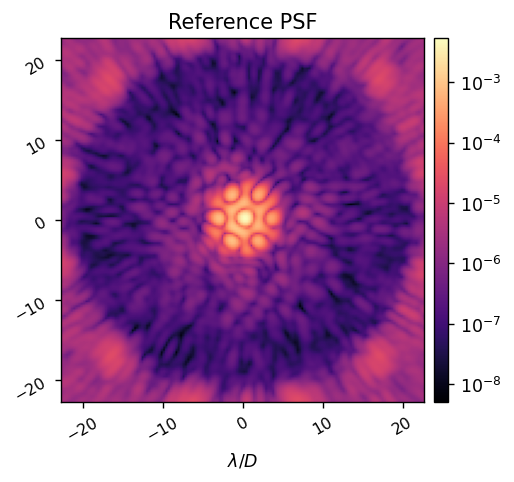

(CGI pid=347795) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 63x across cluster]
(CGI pid=347973) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 14x across cluster]
(CGI pid=347973)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 14x across cluster]


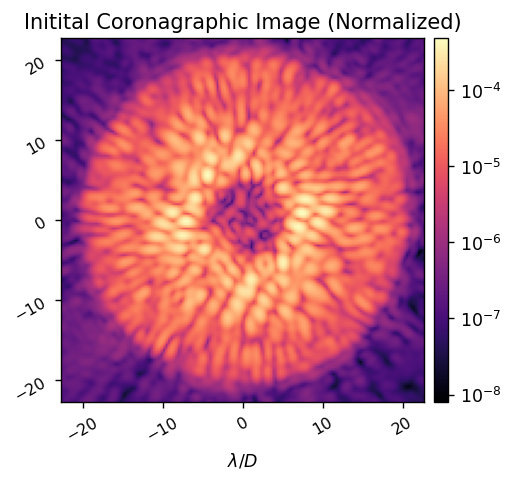

In [11]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, )

max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref

mode.set_actor_attr('use_fpm',True)

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True,)


# With noise

1.3624486320346218e-17 sr
	Flux for wavelength 7.838e-07 m: 5.094e+08 ph / (s m2)
	Flux for wavelength 7.975e-07 m: 4.856e+08 ph / (s m2)
	Flux for wavelength 8.113e-07 m: 4.632e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 4.422e+08 ph / (s m2)
	Flux for wavelength 8.388e-07 m: 4.224e+08 ph / (s m2)
	Flux for wavelength 8.525e-07 m: 4.038e+08 ph / (s m2)
	Flux for wavelength 8.663e-07 m: 3.862e+08 ph / (s m2)
Total flux: 3.113e+09 ph / (s m2)


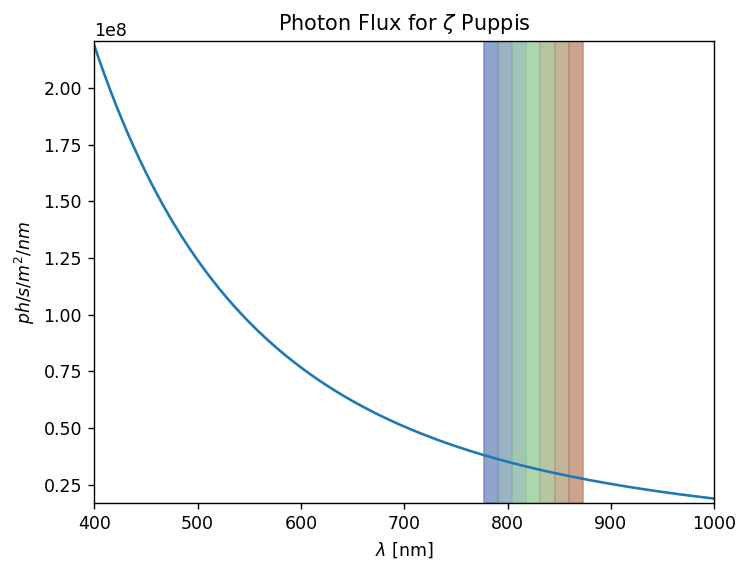

In [13]:
reload(cgi_phasec_poppy.source_flux)

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
    actors[i].setattr.remote('source_flux', source_fluxes[i])
print(f'Total flux: {total_flux:.3e}')

(CGI pid=347795) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 63x across cluster]
(CGI pid=347973) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 14x across cluster]
(CGI pid=347973)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 14x across cluster]


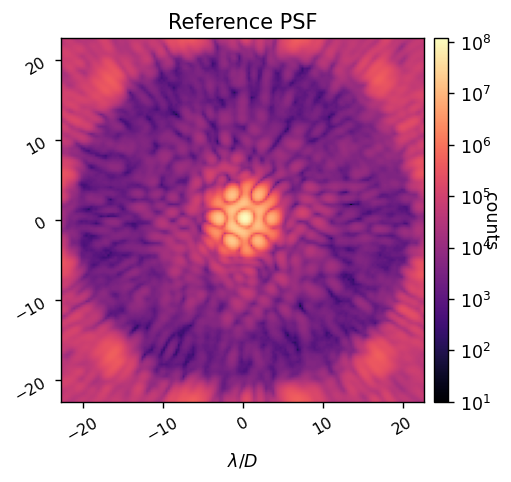

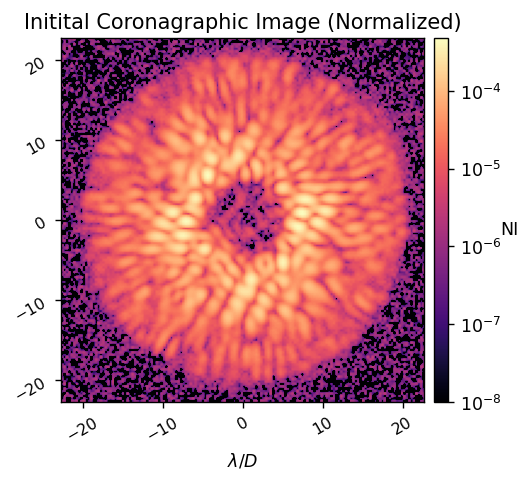

In [17]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        cbar_label='counts', clabel_rot=270,
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, vmin=1e1)

mode.set_actor_attr('use_fpm',True)
max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref
mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 2*u.s
mode.gain = 1

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        cbar_label='NI', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, vmin=1e-8)


In [25]:
reload(cgi_phasec_poppy.imshows)
from cgi_phasec_poppy.imshows import *